In [13]:
from __future__ import division

In [14]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')
np.random.seed(1234)

np.set_printoptions(formatter={'all':lambda x: '%.3f' % x})

In [15]:
from IPython.display import Image
from numpy.core.umath_tests import matrix_multiply as mm

In [16]:
from scipy.optimize import minimize
from scipy.stats import bernoulli, binom

概要（Outline）
----

- 复习詹森不等式（Jensen's inequality）
- 对数函数（log function）的凸性（Concavity）
- 抛硬币的例子（Example of coin tossing with missing informaiton to provide ）context
- 期望最大化方程（EM equations）的推导（Derivation）
- EM方程收敛性（convergence）的演示（Illustration）
- 抛硬币例子中的更新方程推导（Derivation of update equations of coin tossing example）
- 抛硬币例子的代码（Code for coin tossing example）
- 高斯混合更新方程的推导（Derivation of update equatiosn for mixture of Gaussians）
- 高斯混合的代码（Code for mixture of Gaussians）

詹森不等式（Jensen's inequality）
----

首先需要有一个凸函数（convex function） $f$, $E[f(x) \geq f(E[x])$。如果函数是凹函数（concave function），翻转符号（Flip the signe）就可以了。 

如果$f(x)$在整个定义域（domain）内，一个函数的二阶导数都大于零，即 $f''(x) \geq 0$，就说这个函数是凸函数。例如，$f(x) = \log x$, 则二阶导数为 $f''(x) = -1/x^2$，所以在$x \in (0, \infty]$这个区间上，对数函数（log function）就是凹的（concave）。对詹森不等式（Jensen's inequality）的图解如下所示：


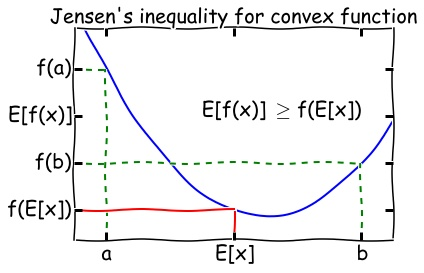

In [4]:
from IPython.display import Image
Image(filename='figs/jensen.jpg')

这个詹森不等式（Jensen's inequality）什么时候是等式（equality）呢？根据上图，可以看到只有当函数$f(x)$是常数（constant）的时候才行。下文中后续的一些内容中我们会再说到这一点。

有完整信息的最大似然估计（Maximum likelihood with complete information）
----

设想一个实验，硬币$A$ 抛出人头（heads）的概率为$\theta_A$，而另一枚硬币$B$ 抛出背面（tails）的概率为$\theta_B$。  接下来进行$m$次试验 - 每次都从两枚硬币当中二选一，然后抛十次（flip it 10 times），然后记录下来人头和背面的次数。如果每次我们也记录了选中的是哪一枚硬币，那么就说具有*完整信息（complete information）*，可以以闭合形式（closed form）来估计出$\theta_A$和$\theta_B$。具体来说，假设我们进行了 5 次试验，即 m=5，然后得到的值记做向量$x$，然后这五次中选择的硬币依次为 $A, A, B, A, B$。这样得到的完整信息的对数似然函数（log likelihood）为：

$$
\log p(x_1; \theta_A) + \log p(x_2; \theta_A) +\ log p(x_3; \theta_B) + \log p(x_4; \theta_A) +\log p(x_5; \theta_B)
$$

其中的$p(x_i; \theta)$ 是二项式分布（binomial distribtion）的多项式函数（PMF），参数$n=m$，$p=\theta$。 接下来我们用$z_i$ 来表示第 $i^\text{th}$ 个硬币的抛出结果，这就不论用的是硬币$A$还是$B$，结果都是正背两面了。

### 最小化求解完整似然估计（Solving for complete likelihood using ）minimization

In [ ]:
def neg_loglik(thetas, n, xs, zs):
    return -np.sum([binom(n, thetas[z]).logpmf(x) for (x, z) in zip(xs, zs)])

In [ ]:
m = 10
theta_A = 0.8
theta_B = 0.3
theta_0 = [theta_A, theta_B]

coin_A = bernoulli(theta_A)
coin_B = bernoulli(theta_B)

xs = map(sum, [coin_A.rvs(m), coin_A.rvs(m), coin_B.rvs(m), coin_A.rvs(m), coin_B.rvs(m)])
zs = [0, 0, 1, 0, 1]
xs

#### 解析解（Analytic solution）

In [ ]:
ml_A = np.sum(np.array(xs)[[0,1,3]]/(m))/3
ml_B = np.sum(np.array(xs)[[2,4]]/(m))/2
ml_A, ml_B

#### 优化（Optimization）

In [ ]:
bnds = [(0,1), (0,1)]
minimize(neg_loglik, [0.5, 0.5], args=(m, xs, zs), 
         bounds=bnds, method='tnc', options={'maxiter': 100})

不完整信息（Incomplete information）的情况
----

然而，如果没有记录下每次用的是哪个硬币，那就存在*缺失数据（missing data）*，这样这个问题就更难解了。对于这种情况，有一种解决思路，就是看看是不是能够对每次试验设置一个对应的权重（weights）$w_i$ ，表示这次试验用硬币$A$或者硬币$B$的概率。直观来看，似乎这个权重应该是关于$z_i$的后验概率分布（posterior distribution），也就是：

$$
w_i = p(z_i \ | \ x_i; \theta)
$$

假设我们对上面参数$\theta$有某种估计，如果知道了$z_i$，就可以估计$\theta$了，因为这样就跟上面完整信息的时候得到了一样的完整似然函数（complete likelihood）。所以在期望最大化（Expectation Maximization，缩写为EM)算法的背后，基础的思路就是开始先对参数$\theta$进行一个简单地猜测，然后计算一下$z$，然后使用这个计算得到的新的$z$的值来更新对$\theta$的估计，这样一直重复下去，直到收敛。下面的推导展示了这种使用“交替更新（alternating updates）”的 EM 算法的有效性。

用语言对这个推导过程进行一下概括就是：首先将对数似然函数看做是一个曲线或者曲面，其中的基为（base）$\theta$。另外寻找一个关于$\theta$的函数$Q$，这个函数是对数似然函数的的一个下界，但与对数似然函数在某一$\theta$点相切，这就是 E 步骤。接下来找到使这个函数$Q$取最大值的$\theta$值，这就是 M 步骤。然后再找另外一个新的关于$\theta$的函数$Q$，还是要满足在新得到的$\theta$值位置与对数似然函数相切，重复上面的步骤获得又一个新的$\theta$值。重复这个过程，直到收敛。在收敛的时候，这个相切的下界函数的最大值实际上就可以视作是我们要找的对数似然函数的最大值了。具体过程如下图所示：

In [ ]:
# Image from http://www.nature.com/nbt/journal/v26/n8/extref/nbt1406-S1.pdf
Image(filename='figs/em.png', width=800)

还没有明确解决的剩下的一步就是该怎样去找到对数似然函数的那些下界相切函数了。这就需要用到詹森不等式了（Jensen's inequality）。接下来我们就要给出这个推导过程。

### 推导过程（Derivation）


在 E 步骤，我们要指定一个函数，这个函数需要是对数似然函数的下界函数。

\begin{align}
ll &= \sum_i{\log p(x_i; \theta)} && \text{对数似然函数的定义} \\
&= \sum_i \log \sum_{z_i}{p(x_i, z_i; \theta)} && \text{增加潜在变量$z$} \\
&= \sum_i \log \sum_{z_i} Q_i(z_i) \frac{p(x_i, z_i; \theta)}{Q_i(z_i)} && \text{$Q_i$ 是关于 $z_i$的一个分布} \\
&= \sum_i \log E_{z_i}[\frac{p(x_i, z_i; \theta)}{Q_i(z_i)}] && \text{求期望（expectations），对应着 EM 算法当中的 E 这个字母} \\
&\geq \sum E_{z_i}[\log \frac{p(x_i, z_i; \theta)}{Q_i(z_i)}] && \text{对对数函数使用詹森规则（Jensen's rule），利用对数函数的凹性（concave）} \\
&\geq \sum_i \sum_{z_i} Q_i(z_i) \log \frac{p(x_i, z_i; \theta)}{Q_i(z_i)} && \text{Q 函数}
\end{align}

如何选择分布$Q_i$？我们需要这个函数$Q$与对数似然函数相切，然后还知道詹森不等式（Jensen's inequality）仅当函数为常数（constant）的时候才为等式的形式。所以则有：


\begin{align}
\frac{p(x_i, z_i; \theta)}{Q_i(z_i)} =& c \\
\implies Q_i(z_i) &\propto p(x_i, z_i; \theta)\\
\implies Q_i(z_i) &= \frac{p(x_i, z_i; \theta) }{\sum_{z_i}{p(x_i, z_i; \theta)}} &&\text{这是因为 $Q$ 是一个概率分布，所以综合必然是1} \\
\implies Q_i(z_i) &= \frac{p(x_i, z_i; \theta) }{{p(x_i, \theta)}} && \text{边界化（marginalizing） $z_i$}\\
\implies Q_i(z_i) &= p(z_i | x_i; \theta) && \text{这一步是根据定义（definition）}
\end{align}

因此$Q_i$就是对$z_i$的这样一个后验概率分布（posterior distribution），这样就完成了 E 步骤了。

在 M 步骤，需要找出能够让函数$Q$取最大值的$\theta$值，然后迭代回去，这样在 E、M 两个步骤之间来回迭代，直到收敛（convergence）。

综上，我们会发现，EM 算法是用于最大似然估计优化（maximum likelikhood optimization）的方法，可以适用于存在缺失信息（missing information）的情况，也可以适用于其他需要添加潜在变量（latent augmented variables）来简化最大似然函数计算（maximum likelihood calculatoins）的情况。

#### 抛硬币试验的例子引用自 [ 《nature》上的这篇《什么是期望最大化算法（What is the expectation maximization algorithm?）》](http://www.nature.com/nbt/journal/v26/n8/full/nbt1406.html)



对 E 步骤，有：

\begin{align}
w_j &= Q_i(z_i = j) \\
&= p(z_i = j | x_i; \theta) \\
&= \frac{p(x_i | z_i = j; \theta) p(z_i = j; \phi)}  {\sum_{l=1}^k{p(x_i | z_i = l; \theta) p(z_i = l; \phi)}}  && \text{贝叶斯规则（Baye's rule）} \\
&= \frac{\theta_j^h(1-\theta_j)^{n-h} \phi_j}{\sum_{l=1}^k \theta_l^h(1-\theta_l)^{n-h} \phi_l} \\
&= \frac{\theta_j^h(1-\theta_j)^{n-h} }{\sum_{l=1}^k \theta_l^h(1-\theta_l)^{n-h} } && \text{假设 $\phi$ 为固定值，这是为了简单考虑}
\end{align}

对 M 步骤，需要找到让下面表达式取最大值的$\theta$值：

\begin{align}
& \sum_i \sum_{z_i} Q_i(z_i) \log \frac{p(x_i, z_i; \theta)}{Q_i(z_i)} \\
&= \sum_{i=1}^m \sum_{j=1}^k w_j \log \frac{p(x_i | z_i=j; \theta) \, p(z_i = j; \phi)}{w_j} \\
&= \sum_{i=1}^m \sum_{j=1}^k w_j \log \frac{\theta_j^h(1-\theta_j)^{n-h} \phi_j}{w_j} \\
&= \sum_{i=1}^m \sum_{j=1}^k w_j \left( h \log \theta_j + (n-h) \log (1-\theta_j) + \log \phi_j - \log w_j \right)
\end{align}


可以微分（differentiate）然后求解导数为零（derivative vanishes）的$\theta_s$值。

\begin{align}
\sum_{i=1}^m w_s \left( \frac{h}{\theta_s} - \frac{n-h}{1-\theta_s} \right) &= 0  \\
\implies \theta_s &= \frac {\sum_{i=1}^m w_s h}{\sum_{i=1}^m w_s n}
\end{align}


### 首个确定解（First explicit solution）

In [ ]:
def mn_ll(y, theta, axis=None):
    """Log likelihood for multinomial distribution (ignoring constant)."""
    return np.sum(y * np.log(theta), axis=axis)
    # return np.sum(y * np.log(theta))

def ll(y, theta, p):
    """Complete log likelihood for mixture."""
    return np.sum(p * mm_ll(y, theta))

def normalize(xs, axis=1):
    """Return normalized marirx so that sum of row or column (default) entries = 1."""
    if axis==0:
        return xs/xs.sum(0)
    else:
        return xs/xs.sum(1)[:, None]

In [ ]:
xs = np.array([(5,5), (9,1), (8,2)]) # , (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

tol = 0.01
max_iter = 100

ll_old = 0
for i in range(max_iter):
    exp_A = []
    exp_B = []
    
    lls_A = []
    lls_B = []
    
    ws_A = []
    ws_B = []
    
    ll_new = 0

    # E-step: calculate probability distributions over possible completions
    for x in xs:

        ll_A = mn_ll(x, thetas[0])
        ll_B = mn_ll(x, thetas[1])
      
        lls_A.append(ll_A)
        lls_B.append(ll_B)
        
        denom = np.exp(ll_A) + np.exp(ll_B)       
        w_A = np.exp(ll_A)/denom
        w_B = np.exp(ll_B)/denom
        
        ws_A.append(w_A)
        ws_B.append(w_B)

        exp_A.append(np.dot(w_A, x))
        exp_B.append(np.dot(w_B, x))
        
        # update complete log likelihood
        ll_new += w_A * ll_A + w_B * ll_B
    
    # M-step: update values for parameters given current distribution
    thetas[0] = np.sum(exp_A, 0)/np.sum(exp_A)
    thetas[1] = np.sum(exp_B, 0)/np.sum(exp_B)
    # print distribution of z for each x and current parameter estimate
    
    print "Iteration: %d" % (i+1)
    print "theta_A = %.2f, theta_B = %.2f, ll = %.2f" % (thetas[0,0], thetas[1,0], ll_new)

    if np.abs(ll_new - ll_old) < tol:
        break
    ll_old = ll_new

### 向量化（Vectorizing ...）

In [ ]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

tol = 0.01
max_iter = 100

ll_old = -np.infty
for i in range(max_iter):
    ll_A = np.sum(xs * np.log(thetas[0]), axis=1)
    ll_B = np.sum(xs * np.log(thetas[1]), axis=1)
    denom = np.exp(ll_A) + np.exp(ll_B)
    w_A = np.exp(ll_A)/denom
    w_B = np.exp(ll_B)/denom

    exp_A = w_A[:, None] * xs
    exp_B = w_B[:, None] * xs
    
    thetas[0] = np.sum(exp_A, 0)/np.sum(exp_A)
    thetas[1] = np.sum(exp_B, 0)/np.sum(exp_B)

    ll_new = w_A.dot(ll_A) + w_B.dot(ll_B)
    
    print "Iteration: %d" % (i+1)
    print "theta_A = %.2f, theta_B = %.2f, ll = %.2f" % (thetas[0,0], thetas[1,0], ll_new)
    
    if np.abs(ll_new - ll_old) < tol:
        break
    ll_old = ll_new

### 写成函数（Writing as a function）

In [ ]:
def em(xs, thetas, max_iter=100, tol=1e-6):
    """Expectation-maximization for coin sample problem."""
    
    ll_old = -np.infty
    for i in range(max_iter):
        ll = np.array([np.sum(xs * np.log(theta), axis=1) for theta in thetas])    
        lik = np.exp(ll)
        ws = lik/lik.sum(0)
        exps = np.array([w[:, None] * xs for w in ws])
        thetas = np.array([expr.sum(0)/expr.sum() for expr in exps])
        ll_new = np.sum([w*l for w, l in zip(ws, ll)])
        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
    return i, thetas, ll_new

### 检验（Checking）

In [ ]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

i, thetas, ll = em(xs, thetas)
print i
for theta in thetas:
    print theta
print ll

### 创建随机数据（Make up some data）

In [ ]:
np.random.seed(1234)

n = 100
p0 = 0.8
p1 = 0.35
xs = np.concatenate([np.random.binomial(n, p0, n/2), np.random.binomial(n, p1, n/2)])
xs = np.column_stack([xs, n-xs])
np.random.shuffle(xs)

### 使用多重随机起始点的 EM 算法（EM with multiple random starts）

In [ ]:
results = [em(xs, np.random.random((2,2))) for i in range(10)]
i, thetas, ll =  sorted(results, key=lambda x: x[-1])[-1]
print i
for theta in thetas:
    print theta
print ll

高斯混合模型（Gaussian mixture models）
----

将 $k$ 个高斯分布（Gaussians）混合到一起，就有了下面的概率分布函数（PDF）

\begin{align}
p(x) = \sum_{j=1}^k \alpha_j \phi(x; \mu_j, \Sigma_j)
\end{align}

其中的 $\alpha_j$ 是第 $j^\text{th}$ 个高斯分布单元（Gaussain component）的权重（weight） 

\begin{align}
\phi(x; \mu, \Sigma) = \frac{1}{(2 \pi)^{d/2}|\Sigma|^{1/2}} \exp \left( -\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu) \right)
\end{align}

假设我们观测到了 $y_1, y2, \ldots, y_n$ 作为一个混合高斯分布（a mixture of Gaussians）的样本（sample）。对数似然函数（log-likeihood）则为：

\begin{align}
l(\theta) = \sum_{i=1}^n \log \left( \sum_{j=1}^k \alpha_j \phi(y_i; \mu_j, \Sigma_j) \right)
\end{align}

其中的 $\theta = (\alpha, \mu, \Sigma)$

这种对数似然函数没有能以闭合形式（closed form）来最大化的参数（parameters），很难直接最大化。

使用 EM 算法
----

假设我们增加一个潜在变量（latent variable）$z$，表示我们观测到的$y$是$k$个高斯分布中的哪一个。这样对 E 步骤和 M 步骤的推导就跟玩具样例（toy example）里面一样了，只不过增加了代数上的复杂度（only with more algebra）。


对于 E 步骤，有：

\begin{align}
w_j^i &= Q_i(z^i = j) \\
&= p(z^i = j | y^i; \theta) \\
&= \frac{p(y^i | z^i = j; \mu, \Sigma) p(z^i = j; \alpha)}  {\sum_{l=1}^k{p(y^i | z^i = l; \mu, \Sigma) p(z^i = l; \alpha)}}  && \text{Baye's rule} \\
&= \frac{\phi(y^i; \mu_j, \Sigma_j) \alpha_j}{\sum_{l=1}^k \phi(y^i; \mu_l, \Sigma_l) \alpha_l}
\end{align}



对于 M 步骤，我们需要找到能让$Q$最大化的参数$\theta = (w, \mu, \Sigma)$：

\begin{align}
\sum_{i=1}^{m}\sum{j=1}^{k} Q(z^i=j) \log \frac{p(x^i | z^i= j; \mu, \Sigma) p(z^i=j; \alpha)}{Q(z^i=j)}
\end{align}

By taking derivatives with respect to $(w, \mu, \Sigma)$ respectively and solving (remember to use Lagrange multipliers for the constraint that $\sum_{j=1}^k w_j = 1$), we get


通过取关于$(w, \mu, \Sigma)$的导数，然后求解（这时候要用到拉格朗日乘数（Lagrange multipliers）作为约束条件，$\sum_{j=1}^k w_j = 1$），就能得到：

\begin{align}
\alpha_j &= \frac{1}{m} \sum_{i=1}^{m} w_j^i \\
\mu_j &= \frac{\sum_{i=1}^{m} w_j^i x^i}{\sum_{i=1}^{m} w_j^i} \\
\Sigma_j &= \frac{\sum_{i=1}^{m} w_j^i (x^i - \mu)(x^i - \mu)^T}{\sum_{i1}^{m} w_j^i}
\end{align}

In [ ]:
from scipy.stats import multivariate_normal as mvn

def normalize(xs, axis=None):
    """Return normalized marirx so that sum of row or column (default) entries = 1."""
    if axis is None:
        return xs/xs.sum()
    elif axis==0:
        return xs/xs.sum(0)
    else:
        return xs/xs.sum(1)[:, None]

def mix_mvn_pdf(xs, pis, mus, sigmas):
    return np.array([pi*mvn(mu, sigma).pdf(xs) for (pi, mu, sigma) in zip(pis, mus, sigmas)])

In [ ]:
def em_gmm_orig(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0)

        # M-step
        pis = np.zeros(k)
        for j in range(len(mus)):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n

        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * xs[i]
            mus[j] /= ws[j, :].sum()

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()

        # update complete log likelihoood 
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

向量化版本（Vectorized version）
----

In [ ]:
def em_gmm_vect(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(k):
            ws[j, :] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs)
        ws /= ws.sum(0)

        # M-step
        pis = ws.sum(axis=1)
        pis /= n

        mus = np.dot(ws, xs)
        mus /= ws.sum(1)[:, None]

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            ys = xs - mus[j, :]
            sigmas[j] = (ws[j,:,None,None] * mm(ys[:,:,None], ys[:,None,:])).sum(axis=0)
        sigmas /= ws.sum(axis=1)[:,None,None]

        # update complete log likelihoood 
        ll_new = 0
        for pi, mu, sigma in zip(pis, mus, sigmas):
            ll_new += pi*mvn(mu, sigma).pdf(xs)
        ll_new = np.log(ll_new).sum()

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

用爱因斯坦求和符号的矢量化（Vectorization with Einstein summation notation）
----

In [ ]:
def em_gmm_eins(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j, (pi, mu, sigma) in enumerate(zip(pis, mus, sigmas)):
            ws[j, :] = pi * mvn(mu, sigma).pdf(xs)
        ws /= ws.sum(0)

        # M-step
        pis = np.einsum('kn->k', ws)/n
        mus = np.einsum('kn,np -> kp', ws, xs)/ws.sum(1)[:, None]
        sigmas = np.einsum('kn,knp,knq -> kpq', ws, 
            xs-mus[:,None,:], xs-mus[:,None,:])/ws.sum(axis=1)[:,None,None]

        # update complete log likelihoood 
        ll_new = 0
        for pi, mu, sigma in zip(pis, mus, sigmas):
            ll_new += pi*mvn(mu, sigma).pdf(xs)
        ll_new = np.log(ll_new).sum()

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

对几种不同 EM 方法的比较（Comparison of EM routines）
----

In [ ]:
np.random.seed(123)

# create data set
n = 1000
_mus = np.array([[0,4], [-2,0]])
_sigmas = np.array([[[3, 0], [0, 0.5]], [[1,0],[0,2]]])
_pis = np.array([0.6, 0.4])
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n)) 
                    for pi, mu, sigma in zip(_pis, _mus, _sigmas)])

# initial guesses for parameters
pis = normalize(np.random.random(2))
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2)

In [ ]:
%%time
ll1, pis1, mus1, sigmas1 = em_gmm_orig(xs, pis, mus, sigmas)

In [ ]:
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T

z = np.zeros(len(_ys))
for pi, mu, sigma in zip(pis1, mus1, sigmas1):
    z += pi*mvn(mu, sigma).pdf(_ys)
z = z.reshape((intervals, intervals))

ax = plt.subplot(111)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)
plt.contour(X, Y, z, N=10)
plt.axis([-8,6,-6,8])
ax.axes.set_aspect('equal')
plt.tight_layout()

In [ ]:
%%time
ll2, pis2, mus2, sigmas2 = em_gmm_vect(xs, pis, mus, sigmas)

In [ ]:
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T

z = np.zeros(len(_ys))
for pi, mu, sigma in zip(pis2, mus2, sigmas2):
    z += pi*mvn(mu, sigma).pdf(_ys)
z = z.reshape((intervals, intervals))

ax = plt.subplot(111)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)
plt.contour(X, Y, z, N=10)
plt.axis([-8,6,-6,8])
ax.axes.set_aspect('equal')
plt.tight_layout()

In [ ]:
%%time
ll3, pis3, mus3, sigmas3 = em_gmm_eins(xs, pis, mus, sigmas)

In [ ]:
# %timeit em_gmm_orig(xs, pis, mus, sigmas)
%timeit em_gmm_vect(xs, pis, mus, sigmas)
%timeit em_gmm_eins(xs, pis, mus, sigmas)

In [ ]:
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T

z = np.zeros(len(_ys))
for pi, mu, sigma in zip(pis3, mus3, sigmas3):
    z += pi*mvn(mu, sigma).pdf(_ys)
z = z.reshape((intervals, intervals))

ax = plt.subplot(111)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)
plt.contour(X, Y, z, N=10)
plt.axis([-8,6,-6,8])
ax.axes.set_aspect('equal')
plt.tight_layout()